In [1]:
import torch 
from torch import nn
from torch.utils.data import random_split
import numpy as np
import torch.optim as optim
torch.manual_seed(42)

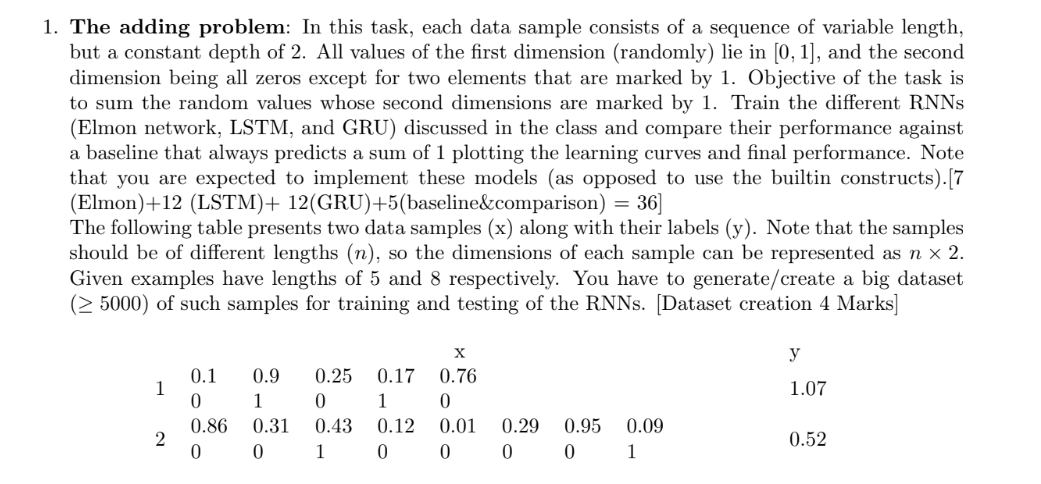

In [2]:
def generate_sample(low = 2, high = 10):
    """
    Generates a sample of random length between 'low' and 'high', with random values b/w [0, 1] in the 1st dimension
    and with two 1s in the 2nd dimension. 
    The label = sum of the random values whose 2nd dimensions are marked by 1.
    
    Returns :
        x: A 2D array of random length b/w 'low' and 'high'
        y: The sum of the random values whose 2nd dimensions are marked by 1
    """
    # n = length of sequence b/w 2 and 10 by default
    n = np.random.randint(low, high)
    
    # x is a 2D vector , 1st dimension contains values b/w 0 and 1 , 2nd dimension alll 0s
    x = np.random.rand(n, 2)
    x[:, 1] = 0
    
    # Choose any 2 indices randomly and make x[indices, 1] = 1
    rand_indices = np.random.choice(n, 2, replace=False)
    x[rand_indices, 1] = 1
    
    y = x[:, 0] * x[:, 1]
    return x, y.sum()


# n_samples to generate
n_samples = 8000
data = [generate_sample() for _ in range(n_samples)]      # data is a LIST

print(len(data))
print(type(data))
print(data[0])
print(type(data[0]))
print(data[0][0].shape)
print(torch.tensor(data[0][0][0]))
# print(len(data[0]))
# print(data[0][0])
# print(data[0][0].shape)
# print(data[0][1])
# print(data[0][1].shape)

# for i, data in enumerate(data, 0):

#     # Get inputs and labels
#     inputs, labels = data
#     print(inputs)
#     print(type(inputs))
#     print(inputs.shape)
#     print(inputs)
#     print(labels)
    
#     for t in range((inputs.size)//2):
#         print(t)

8000
<class 'list'>
(array([[0.77567967, 0.        ],
       [0.31499132, 0.        ],
       [0.35294445, 1.        ],
       [0.35047392, 0.        ],
       [0.85904716, 0.        ],
       [0.05355854, 1.        ],
       [0.73544117, 0.        ]]), 0.4065029828675728)
<class 'tuple'>
(7, 2)
tensor([0.7757, 0.0000], dtype=torch.float64)


In [3]:
class ElmanNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Initialize weight matrices\
#         use  torch.rand and torch.zeros
# params = []
# torch.matmul(W_xh, torch.FloaYensor(X[i]).reahspe(3,1))
# ht = torch.tanh(a + torch.matmul(W_hh, h) + b_h)
# y = 
        self.W_xh = nn.Parameter(torch.randn(hidden_size, input_size), requires_grad=True)  # 3 x 2  
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size), requires_grad=True) # 3 x 3
        self.W_hy = nn.Parameter(torch.randn(1, hidden_size), requires_grad=True)  # 1 x 3
        self.b_h = nn.Parameter(torch.zeros(hidden_size, 1), requires_grad=True)               # 3 x 1
        self.b_y = nn.Parameter(torch.zeros(1, 1), requires_grad=True)                # 1 x 1
        
        # Initialize hidden state
        self.h_t = torch.zeros(hidden_size, 1)
    
    def forward(self, x):
        """ 
        x : numpy 2D array : 1st dimension b/w [0,1] and 2nd dimension having 1 in 2 places
        Returns:
            y : scalar value : predicted value
        """
#         print(self.W_hy.shape)
        # Loop over time steps
#         print(torch.matmul(self.W_xh.data ,torch.Tensor(x[0])))
#         print(torch.matmul(self.W_hh.data, self.h_t))
        H = self.h_t
        for t in range(x.shape[0]):
            # Compute hidden state at current time step
#             print(torch.matmul(self.W_xh.data ,torch.Tensor(x[t])))
#             print(torch.matmul(self.W_hh.data, self.h_t))
            H = torch.tanh(torch.matmul(self.W_xh.data ,torch.Tensor(x[t]).unsqueeze(1)) + torch.matmul(self.W_hh.data, H) + self.b_h)
#         print(self.W_hy.shape)
        
        # Compute output
#         print(self.h_t.shape)
#         print(self.W_hy.shape)
#         print(torch.matmul(self.W_hy.data, self.h_t).shape)
        y = torch.relu(torch.matmul(self.W_hy.data, H) + self.b_y)
        
        return y
    
    
    def train(self, net, datas, n_epochs = 10):
        """ 
            Trains the network {net} for {n_epochs} epochs using the train data {datas} 
            net : A instantiated neural network class
            datas : Train data is a list of tuples where tuples are of the form ({2D array of variable length}, {label})
            n_epochs : Number of epochs to train for.
                                                                                                                        """
        # Define the optimiser
        optimizer = optim.SGD(net.parameters(), lr=0.05)
        criterion = nn.MSELoss()
        
        # Training loop
        for epoch in range(n_epochs):
            print(epoch)
            running_loss = 0
            for i, data in enumerate(datas, 0):
                
                # Get inputs and labels
                inputs, labels = data
                
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward + backward + optimize
                y_pred = self.forward(inputs)
#                 print(y_pred.squeeze())
#                 print(torch.squeeze(torch.tensor([labels], requires_grad = True).float()))
#                 loss = criterion(y_pred.squeeze(), torch.tensor([labels], requires_grad = True).float())
#                 print(y_pred, torch.tensor([labels]))
                loss = (y_pred - torch.tensor([labels])) * (y_pred - torch.tensor([labels]))
                
                # Compute gradients using backward pass
                loss.backward()
                
                # Update the parameters using the gradients and Adam optimiser
                optimizer.step()

                # Update running loss
                running_loss += loss.detach()
#                 print(i)
#                 print(running_loss)
            
            running_loss = running_loss/len(datas)
            print(f"Epoch {epoch}, Running_loss {running_loss}. ")
                


In [4]:
# Define hyperparameters
input_size = 2
output_size = 1
n_epochs = 10
hidden_sizes = [3]

# n_samples to generate
n_samples = 5000
datas = [generate_sample() for _ in range(n_samples)]      # data is a LIST


# Split dataset into train and validation sets
train_size = int(0.8 * len(datas))
val_size = len(datas) - train_size
train_datas, val_datas = random_split(datas, [train_size, val_size]) 

print(len(train_datas))

for hidden_size in hidden_sizes:
    # Instantiate model and optimizer
    net = ElmanNet(input_size, hidden_size, output_size)
    net.train(net, train_datas, n_epochs)
    

# Prediction
print(val_datas[0])
net.forward(val_datas[0][0])


4000
0
Epoch 0, Running_loss tensor([[0.1826]], dtype=torch.float64). 
1
Epoch 1, Running_loss tensor([[0.1726]], dtype=torch.float64). 
2
Epoch 2, Running_loss tensor([[0.1722]], dtype=torch.float64). 
3
Epoch 3, Running_loss tensor([[0.1719]], dtype=torch.float64). 
4
Epoch 4, Running_loss tensor([[0.1718]], dtype=torch.float64). 
5
Epoch 5, Running_loss tensor([[0.1717]], dtype=torch.float64). 
6
Epoch 6, Running_loss tensor([[0.1716]], dtype=torch.float64). 
7
Epoch 7, Running_loss tensor([[0.1716]], dtype=torch.float64). 
8
Epoch 8, Running_loss tensor([[0.1715]], dtype=torch.float64). 
9
Epoch 9, Running_loss tensor([[0.1715]], dtype=torch.float64). 
(array([[0.46873307, 1.        ],
       [0.07930414, 1.        ]]), 0.5480372107724584)


tensor([[1.0110]], grad_fn=<ReluBackward0>)

In [5]:
torch.tensor([labels]).unsqueeze(1).float()     # labels is float => torch.tensor([labels]) is tensor double => unsqueeze is to make same dimension as y_pred 

IndentationError: unexpected indent (2907842676.py, line 3)

In [ ]:
# torch.tensor([0.523]).float()